# **机器学习公开课 - 机器学习的未来：AutoML与超参数优化**
## Day 2 随机网格搜索与Halving网格搜索

> 节选自《2021机器学习实战》正课<br>
> 作者：@菜菜TsaiTsai<br>
> 版本号：2021/12/04 V2<br>

# <font color="red">今日直播已结束，扫码领取课件/代码>>></font>
# <font color="red">明晚8点直播间：贝叶斯优化</font>
# <font color="red">全场7折进行中，扫码回复“优惠”享折上折</font>

## 0 课程规划

欢迎来到为期三天的《机器学习的未来：AutoML与超参数优化》公开课。在这门课程中，我将用三天时间带你AutoML当前研究现状，并深入了解超参数优化算法中的网格优化与贝叶斯优化。当你完成这门课程时，你将能够自由应用数种网格搜索算法与数种贝叶斯优化算法，同时你将会了解AutoML领域所面临的挑战和机遇。如果想系统地学习更多超参数优化的信息，则可以向客服小可爱咨询正课《2021机器学习实战》。

**DAY 1：AutoML前沿进展与枚举网格搜索**

**DAY 2：随机网格搜索与Halving网格搜索**

**DAY 3：贝叶斯优化与TPE优化**

为掌握这门课程，你需要先掌握：
- Python基础 >> 《九天老师的Python基础》<br>https://www.bilibili.com/video/BV1U54y1W7jw?spm_id_from=333.999.0.0

- 机器学习基础 >> 《2021机器学习实战公开课》<br>包括超参数、泛化能力等基本概念<br>交叉验证等基本工具<br>随机森林等基本算法<br>https://www.bilibili.com/video/BV1f3411r7EP?share_source=copy_web

In [1]:
import re
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

In [2]:
for package in [sklearn,mlp,np,pd]:
    print(re.findall("([^']*)",str(package))[2],package.__version__)

sklearn 1.0.1
matplotlib 3.4.3
numpy 1.20.3
pandas 1.3.4


In [ ]:
#pip install --upgrade scikit-learn
#conda update scikit-learn

### 复习：枚举网格搜索的结果

In [3]:
#参数空间
param_grid_simple = {'n_estimators': [*range(5,100,5)]
                     , 'max_depth': [*range(25,36,2)]
                     , "max_features": ["log2","sqrt","auto"]
                    }

#评估器
reg = RFR(random_state=1412,verbose=True,n_jobs=12)

cv = KFold(n_splits=5,shuffle=True,random_state=1412)

search = GridSearchCV(estimator=reg
                     ,param_grid=param_grid_simple
                     ,scoring = "neg_mean_squared_error" #MSE
                     ,verbose = True
                     ,cv = cv
                     ,n_jobs=12)

In [37]:
#=====【TIME WARNING: 5~10min】=====#
start = time.time()
search.fit(X,y)
print(time.time() - start)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits
53.38564848899841


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  45 out of  45 | elapsed:    0.0s finished


In [33]:
search.best_estimator_

RandomForestRegressor(max_depth=33, max_features='log2', n_estimators=45,
                      n_jobs=12, random_state=1412, verbose=True)

In [34]:
abs(search.best_score_)**0.5 #RMSE

29840.676988215626

## 1 随机网格搜索（Random Grid Search）

- 基本原理

在讲解网格搜索时我们提到，伴随着数据和模型的复杂度提升，网格搜索所需要的时间急剧增加。以随机森林算法为例，如果使用过万的数据，搜索时间则会立刻上升好几个小时。考虑到后续实践过程中，算法和数据都将更加复杂，而建模过程中超参数调优是模型训练的必备环节，因此，我们急需寻找到一种更加高效的超参数搜索方法。

首先，当所使用的算法确定时，决定枚举网格搜索运算速度的因子一共有两个：

> 1 参数空间的大小：参数空间越大，需要建模的次数越多<br>
> 2 数据量的大小：数据量越大，每次建模时需要的算力和时间越多<br>

因此，sklearn中的网格搜索优化方法主要包括两类，其一是**调整搜索空间**，其二是调整**每次训练的数据**。其中，调整参数空间的具体方法，是放弃原本的搜索中必须使用的全域超参数空间，改为挑选出部分参数组合，构造超参数子空间，并只在子空间中进行搜索。以下图的二维空间为例，在这个n_estimators与max_depth共同组成的参数空间中，枚举网格搜索必须对30种参数组合都进行搜索，而调整搜索空间之后，我们只抽样出橙色的参数组合作为“子空间”，并只对橙色参数组合进行搜索。如此一来，整体搜索所需的计算量就大大下降了，原本需要30次建模，现在只需要8次建模。

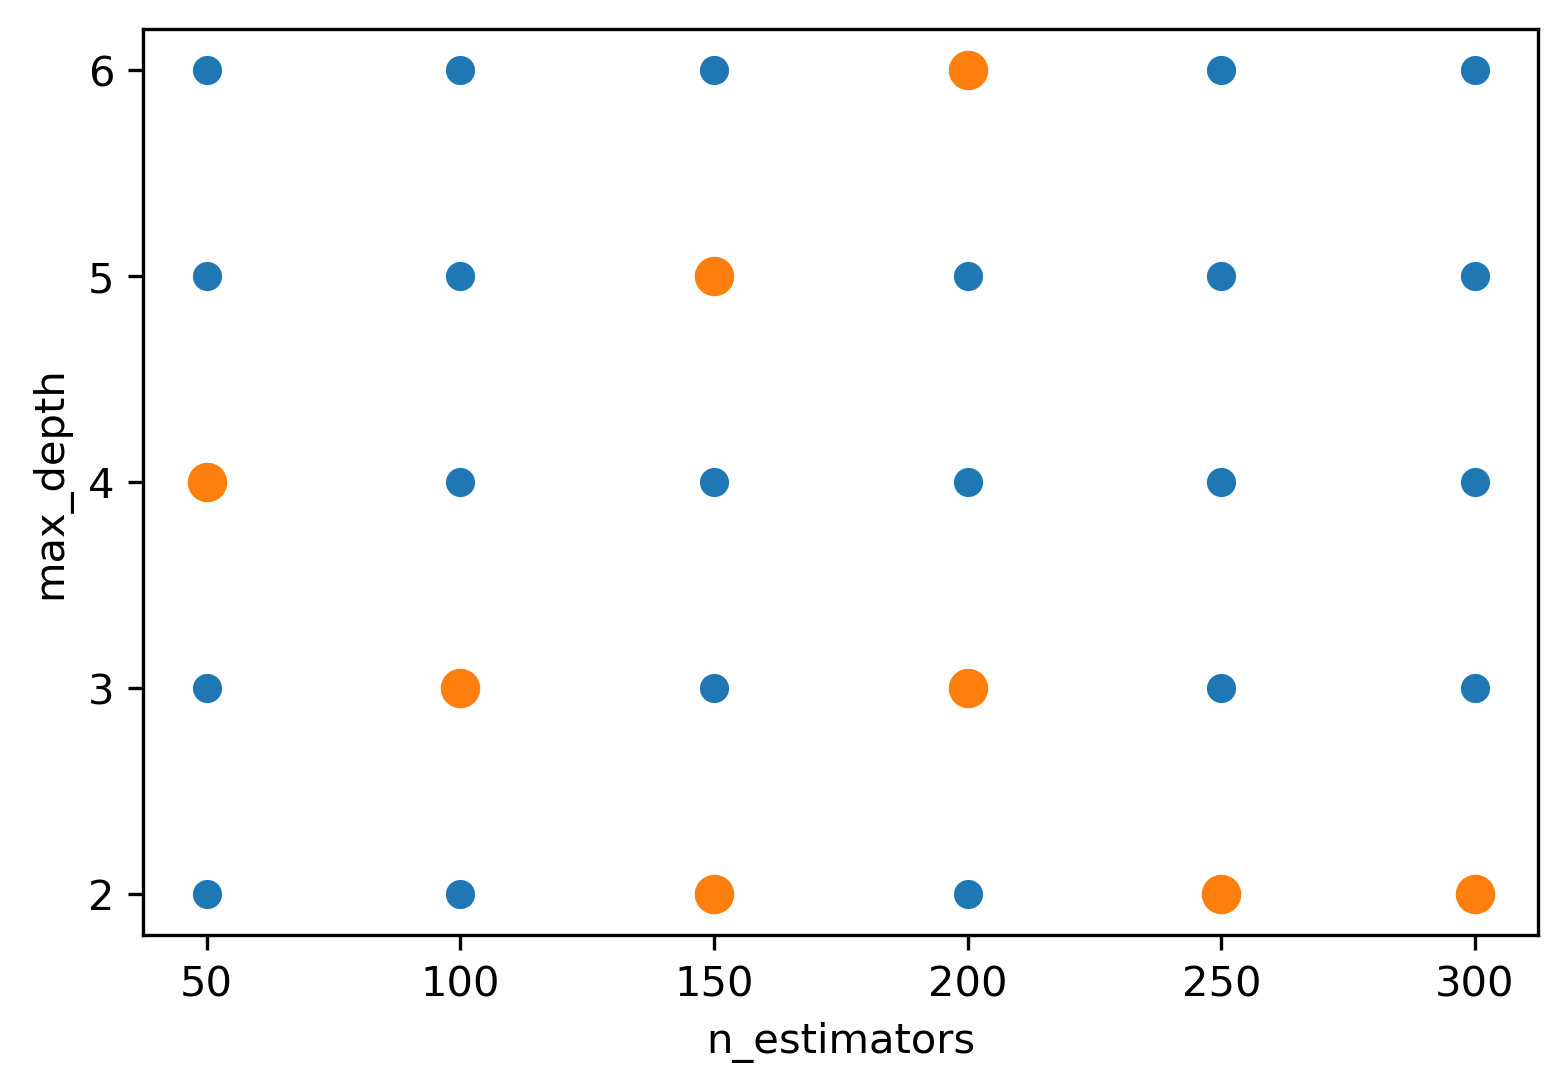

In [69]:
n_e_list = [*range(50,350,50)]
m_d_list = [*range(2,7)]
comb = pd.DataFrame([(n_estimators, max_depth) for n_estimators in n_e_list for max_depth in m_d_list])
plt.figure(dpi=300)
plt.scatter(comb.iloc[:,0],comb.iloc[:,1],cmap="Blues")
plt.scatter([50,250,200,200,300,100,150,150],[4,2,6,3,2,3,2,5],cmap="red",s=20,linewidths=5)
plt.xticks([*range(50,350,50)])
plt.yticks([*range(2,7)])
plt.xlabel("n_estimators")
plt.ylabel("max_depth");

在sklearn中，随机抽取参数子空间并在子空间中进行搜索的方法叫做随机网格搜索RandomizedSearchCV。由于搜索空间的缩小，需要枚举和对比的参数组的数量也对应减少，整体搜索耗时也将随之减少，因此：

> 当设置相同的全域空间时，随机搜索的**运算速度**比枚举网格搜索**快**很多。<br>
> 当设置相同的训练次数时，随机搜索可以**覆盖的空间**比枚举网格搜索**大**很多。<br>
> 同时，绝妙的是，随机网格搜索得出的**最小损失**与枚举网格搜索得出的最小损失**很接近**。

可以说，是提升了运算速度，又没有过多地伤害搜索的精度。

不过，需要注意的是，**随机网格搜索在实际运行时，并不是先抽样出子空间，再对子空间进行搜索**，而是仿佛“循环迭代”一般，在这一次迭代中随机抽取1组参数进行建模，下一次迭代再随机抽取1组参数进行建模，由于这种随机抽样是不放回的，因此不会出现两次抽中同一组参数的问题。我们可以控制随机网格搜索的迭代次数，来控制整体被抽出的参数子空间的大小，这种做法往往被称为“赋予随机网格搜索固定的计算量，当全部计算量被消耗完毕之后，随机网格搜索就停止”。

- 随机网格搜索的实现

In [269]:
from sklearn.model_selection import RandomizedSearchCV

*class* `sklearn.model_selection.RandomizedSearchCV`(estimator, param_distributions, \*, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False)

全部参数解读如下，其中加粗的是随机网格搜索独有的参数：

|Name|Description|      
|:--:|:--:|      
|estimator|调参对象，某评估器|      
|param_distributions|全域参数空间，可以是字典或者字典构成的列表|
|**n_iter**|迭代次数，迭代次数越多，抽取的子参数空间越大|
|scoring|评估指标，支持同时输出多个参数|
|n_jobs|设置工作时参与计算的线程数|
|refit|挑选评估指标和最佳参数，在完整数据集上进行训练|
|cv|交叉验证的折数|
|verbose|输出工作日志形式|
|pre_dispatch|多任务并行时任务划分数量|
|**random_state**|随机数种子|
|error_score|当网格搜索报错时返回结果，选择'raise'时将直接报错并中断训练过程，其他情况会显示警告信息后继续完成训练|
|return_train_score|在交叉验证中是否显示训练集中参数得分|

我们依然借用之前在网格搜索上见过的X和y，以及随机森林回归器，来实现随机网格搜索：

In [270]:
data = pd.read_csv(r"D:\Pythonwork\2021ML\PART 2 Ensembles\datasets\House Price\train_encode.csv",index_col=0)

In [271]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [272]:
X.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [273]:
X.shape

(1460, 80)

In [6]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

- 相同的全域参数空间

In [291]:
#创造参数空间 - 使用与网格搜索时完全一致的空间，以便于对比
param_grid_simple = {'n_estimators': [*range(5,100,5)]
                     , 'max_depth': [*range(25,36,2)]
                     , "max_features": ["log2","sqrt","auto"]
                    }

#建立回归器、交叉验证
reg = RFR(random_state=1412,verbose=True,n_jobs=12)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

In [274]:
#计算全域参数空间大小，这是我们能够抽样的最大值
len([*range(5,100,5)]) * len([*range(25,36,2)]) * 3

342

In [275]:
#定义随机搜索
search = RandomizedSearchCV(estimator=reg
                            ,param_distributions=param_grid_simple
                            ,n_iter = 180 #子空间的大小是全域空间的一半左右
                            ,scoring = "neg_mean_squared_error"
                            ,verbose = True
                            ,cv = cv
                            ,n_jobs=12)

In [298]:
#训练随机搜索评估器
#=====【TIME WARNING: 5~10min】=====#
start = time.time()
search.fit(X,y)
print(time.time() - start)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
32.43994474411011


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  45 out of  45 | elapsed:    0.0s finished


In [301]:
#查看模型结果
search.best_estimator_

RandomForestRegressor(max_depth=35, max_features='log2', n_estimators=45,
                      n_jobs=12, random_state=1412, verbose=True)

In [302]:
abs(search.best_score_)**0.5

29845.83915991588

|HPO方法|网格搜索|随机搜索|
|:-:|:-:|:-:|
|全域空间/实际空间|342/342|180/342|
|搜索时间|53.385|<font color="green">**32.439(↓)**</font>|
|最优分数（RMSE）|29840.676|29845.839|

很明显，在相同参数空间、相同模型的情况下，随机网格搜索的运算速度是普通网格搜索的一半，当然，这与子空间是全域空间的一半有很大的联系。由于随机搜索只是降低搜索的次数，并非影响搜索过程本身，因此其运行时间基本就等于n_iter/全域空间组合数 * 网格搜索的运行时间。

- 随机网格搜索的理论极限

虽然通过缩小子空间可以提升搜索的速度，但是随机网格搜索的精度看起来并没有削减太多，随机网格搜索可以得到和网格搜索一样好的结果吗？它也像网格搜索一样，可以得到最优的参数组合吗？为什么缩小参数空间之后，随机网格搜索的结果还与网格搜索一致？

**理论上来说，枚举网格搜索的上限和随机网格搜索的上限哪个高？**

从直觉上来说，我们很难回答这些问题，但我们可以从数学的随机过程的角度来理解这个问题。在机器学习算法当中，有非常多通过随机来降低运算速度（比如Kmeans，随机挑选样本构建簇心，小批量随机梯度下降，通过随机来减少每次迭代需要的样本）、或通过随机来提升模型效果的操作（比如随机森林，比如极度随机树）。两种随机背后的原理完全不同，而随机网格搜索属于前者，这一类机器学习方法总是伴随着“从某个全数据集/全域中进行抽样”的操作，而这种操作能够有效的根本原因在于：

> - 抽样出的子空间可以一定程度上反馈出全域空间的分布<br><br>
> - 子空间相对越大（含有的参数组合数越多），子空间的分布越接近全域空间的分布<br><br>
> - 当全域空间本身足够密集时，很小的子空间也能获得与全域空间相似的分布<br><br>
> - 如果全域空间包括了理论上的损失函数最小值，那一个与全域空间分布高度相似的子空间很可能也包括损失函数的最小值，或包括非常接近最小值的一系列次小值<br><br>
> - 在与全域空间分布相似的子空间中，随机搜索即便不能找到真正的最小值，也有很高的概率找到与最小值高度接近的某一个次小值<br>

上述数学事实听起来比较抽象，但其实我们可以通过绘制图像来直观地呈现这些事实。许多在数学上比较抽象的概念都可以被可视化。在这里，我们借助matplotlib工具库mplot3d中的一组默认数据。

In [279]:
from mpl_toolkits.mplot3d import axes3d

In [280]:
p1, p2, MSE = axes3d.get_test_data(0.05) #自动获取数据的功能get_test_data
#假设现在有两个参数，p1与p2，两个参数组成的参数组合对应着损失函数值MSE
#参数0.05是指参数空间中，点与点之间的距离
#因此该数字越小，取出来的样本越多

In [281]:
len(p1) #参数1的取值有120个

120

In [282]:
len(p2) #参数2的取值也有120个

120

请问现在参数空间当中一共有多少个参数组合？120*120=14400种组合，所以参数空间中一共有14400个点。

In [7]:
MSE.shape #损失函数值，总共14400个点

(120, 120)

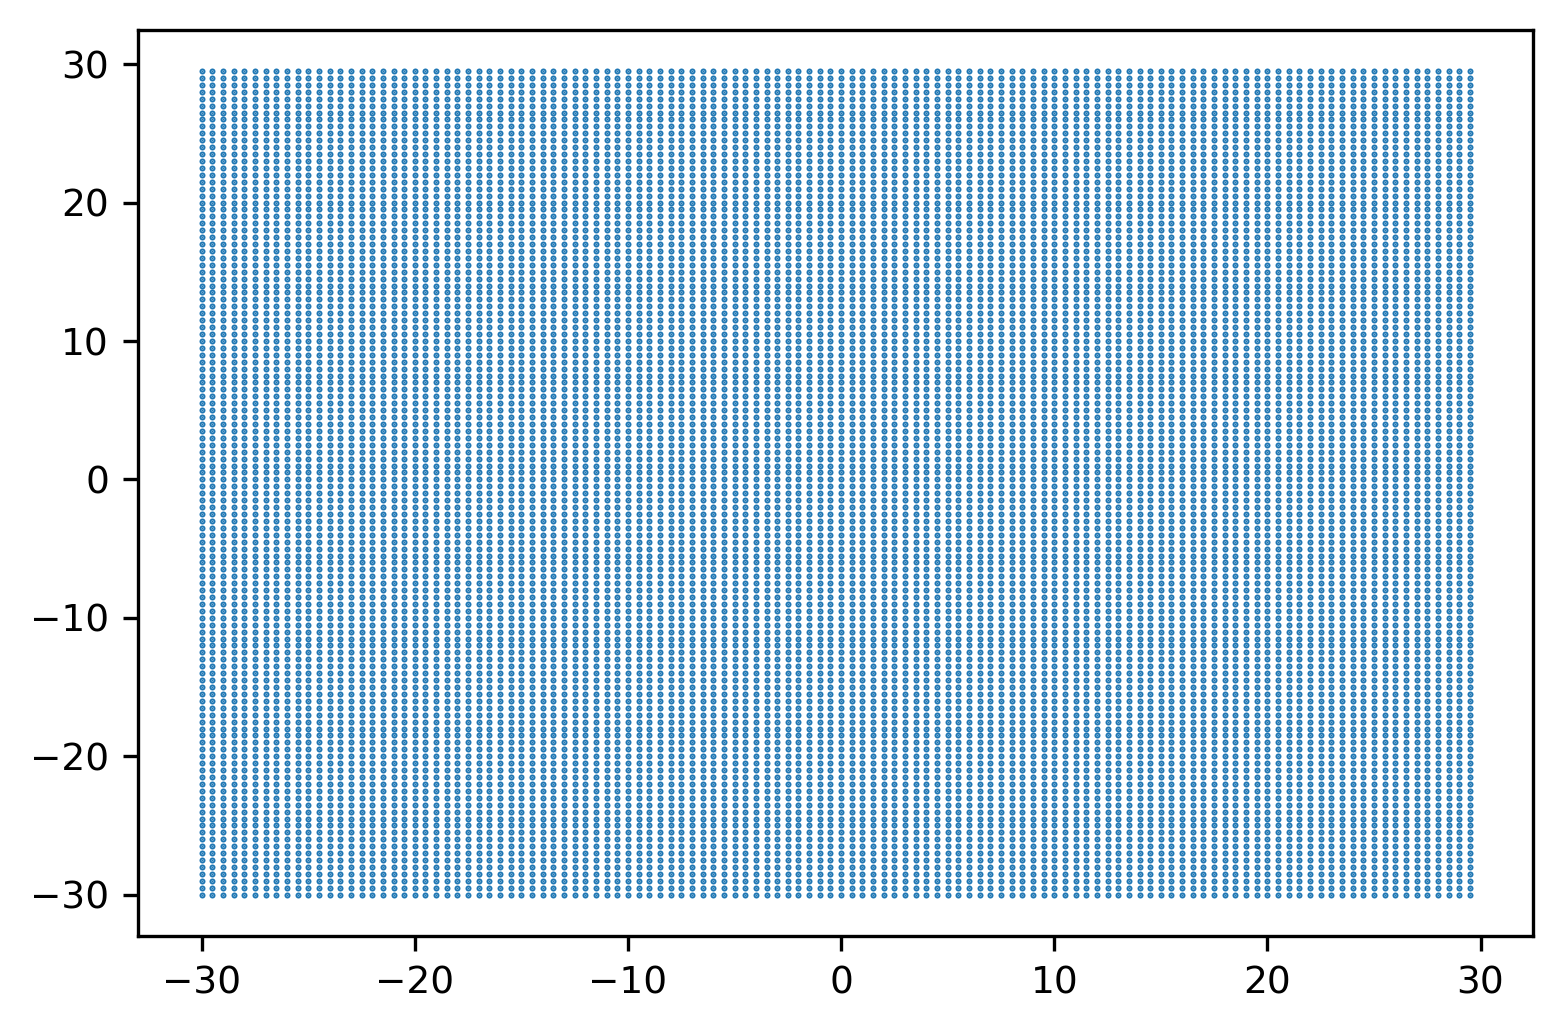

In [8]:
#绘制P1与P2的参数空间 - 这是一个呈现出14400个点的密集空间
plt.figure(dpi=300)
plt.scatter(p1,p2,s=0.2)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9);

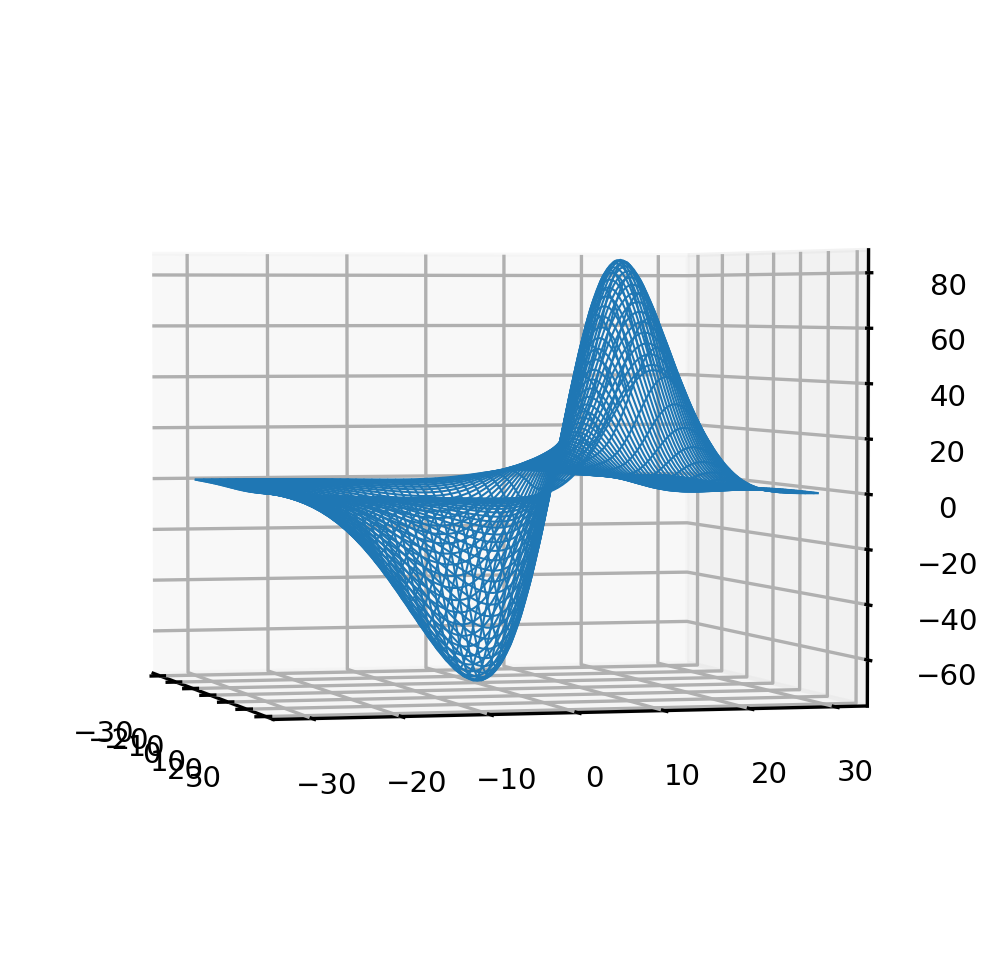

In [302]:
#参数与损失共同构建的函数
p1, p2, MSE = axes3d.get_test_data(0.05)
plt.figure(dpi=300)
ax = plt.axes(projection="3d")
ax.plot_wireframe(p1,p2,MSE,rstride=2,cstride=2,linewidth=0.5)
ax.view_init(2, -15)
ax.zaxis.set_tick_params(labelsize=7)
ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7);

In [284]:
np.min(MSE) #整个参数中，可获得的MSE最小值是-73.39

-73.39620971601681

In [11]:
#现在，我们从该空间上抽取子空间
import numpy as np

In [299]:
#我们从空间中抽取n个组合，n越大子空间越大
#现在总共有14400个组合
#对被抽中的点来说，损失函数的值就是MSE，对没有抽中的点来说，损失函数值是空值
#因此，我们只需要找出没有抽中的点，并让它的损失函数值MSE为空就可以了

n = 2000

-73.2180960309936


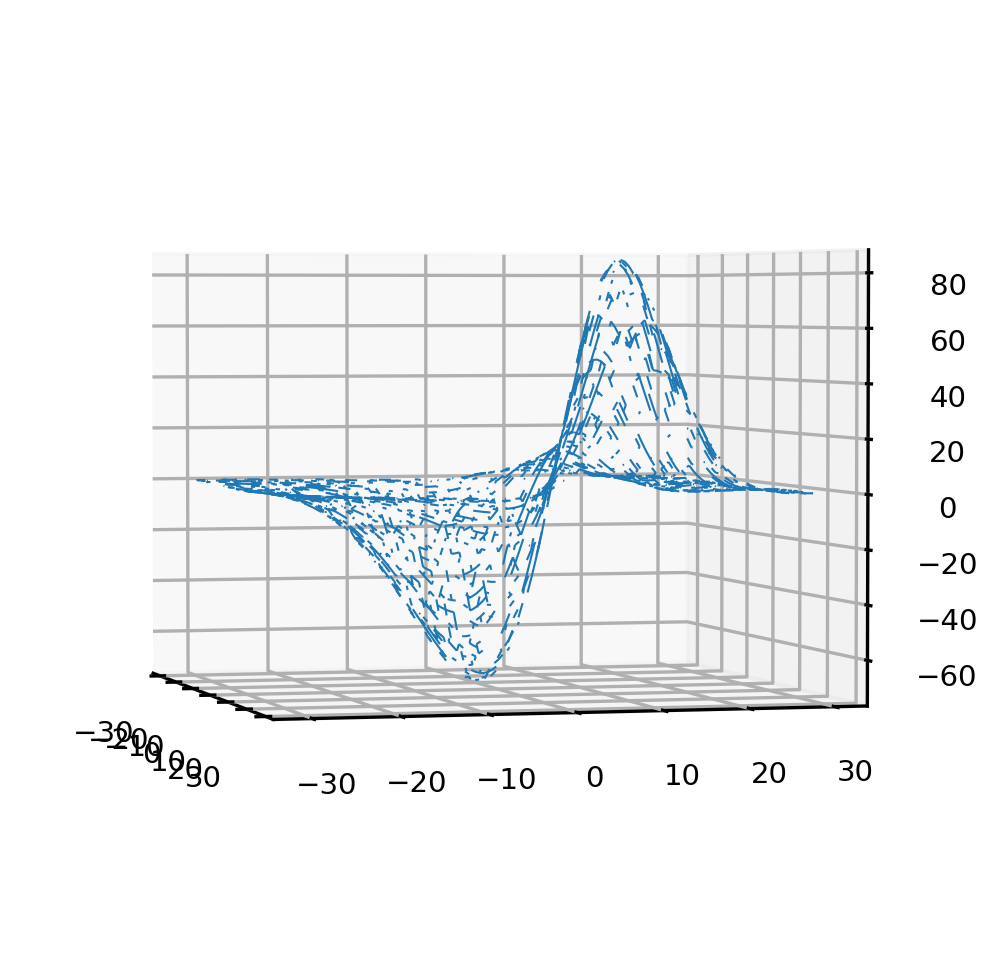

In [301]:
#从0~14400中生成(14400-n)个随机数，形成没有被抽到子空间中的点的索引
unsampled = np.random.randint(0,14400,14400-n)

p1, p2, MSE = axes3d.get_test_data(0.05)

#拉平MSE，并将所有没抽中的点的损失函数变为空值
for i in [p1,p2,MSE]:
    i = i.ravel()
    i[unsampled] = np.nan
    i = i.reshape((120,120))
#设置完毕空值后，记得把MSE恢复成原来的结构，否则绘图报错

#参数与损失共同构建的函数
plt.figure(dpi=300)
ax = plt.axes(projection="3d")
ax.view_init(2, -15)
ax.plot_wireframe(p1,p2,MSE,rstride=2,cstride=2,linewidth=0.5)
ax.zaxis.set_tick_params(labelsize=7)
ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7);

#求出当前损失函数上的最小值
#注意此时因为MSE中含有了空值，因此要先排除空值影响，否则min函数会返回空值
MSE = MSE.ravel().tolist()
MSE = [x for x in MSE if str(x) != 'nan']
print(np.min(MSE))

我们可以在图像上验证如下事实：

> - 抽样出的子空间可以一定程度上反馈出全域空间的分布<br><br>
> - 子空间相对越大（含有的参数组合数越多），子空间的分布越接近全域空间的分布<br><br>
> - 当全域空间本身足够密集时，很小的子空间也能获得与全域空间相似的分布<br><br>
> - 如果全域空间包括了理论上的损失函数最小值，那一个与全域空间分布高度相似的子空间很可能也包括损失函数的最小值，或包括非常接近最小值的一系列次小值<br><br>
> - 在与全域空间分布相似的子空间中，随机搜索即便不能找到真正的最小值，也有很高的概率找到与最小值高度接近的某一个次小值<br>

因此，只要子空间足够大，随机网格搜索的效果一定是高度逼近枚举网格搜索的。**在全域参数空间固定时，随机网格搜索可以在效率与精度之间做权衡**。子空间越大，精度越高，子空间越小，效率越高。

- 更大的全域空间

不过，由于随机网格搜索计算更快，所以在相同计算资源的前提下，我们可以对随机网格搜索使用更大的全域空间，因此随机搜索可能得到比网格搜索更好的效果：

In [14]:
#创造参数空间 - 比网格搜索大一倍的全域空间
param_grid_simple = {'n_estimators': [*range(5,100,5)]
                     , 'max_depth': [*range(25,36,2)]
                     , "max_features": ["log2","sqrt",16,32,64,"auto"]
                    }

In [15]:
#计算全域参数空间大小，这是我们能够抽样的最大值
len([*range(5,100,5)]) * len([*range(25,36,2)]) * 6

684

In [16]:
#建立回归器、交叉验证
reg = RFR(random_state=1412,verbose=True,n_jobs=12)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

#定义随机搜索
search = RandomizedSearchCV(estimator=reg
                            ,param_distributions=param_grid_simple
                            ,n_iter = 360 #使用与枚举网格搜索类似的拟合次数
                            ,scoring = "neg_mean_squared_error"
                            ,verbose = True
                            ,cv = cv
                            ,n_jobs=12)

In [23]:
#训练随机搜索评估器
#=====【TIME WARNING: 5~10min】=====#
start = time.time()
search.fit(X,y)
print(time.time() - start)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
64.65653014183044


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished


In [25]:
#查看最佳评估器
search.best_estimator_

RandomForestRegressor(max_depth=31, max_features=16, n_estimators=85, n_jobs=12,
                      random_state=1412, verbose=True)

In [26]:
#查看最终评估指标
abs(search.best_score_)**0.5

29308.518976476367

|HPO方法|网格搜索|随机搜索|随机搜索|
|:-:|:-:|:-:|:-:|
|搜索空间/全域空间|342/342|180/342|360/684|
|搜索时间|53.385|<font color="green">**32.439(↓)**</font>|64.656|
|最优分数（RMSE）|29840.676|29845.839|<font color="green">**29307.518(↓)**</font>|

可以发现，当全域参数空间增大之后，随即网格搜索可以使用与小空间上的网格搜索相似的时间，来求得更好的结果。除了可以容忍更大的参数空间之外，随机网格搜索还可以接受连续性变量作为参数空间的输入。

- 连续型的参数空间

![](https://miro.medium.com/max/1400/0*yDmmJmvRowl0cSN8.png)

对于网格搜索来说，参数空间中的点是分布均匀、间隔一致的，因为网格搜索无法从某种“分布”中提取数据，只能使用组合好的参数组合点，而随机搜索却可以接受“分布”作为输入。如上图所示，对于网格搜索来说，损失函数的最低点很不幸的、位于两组参数之间，在这种情况下，枚举网格搜索是100%不可能找到最小值的。但对于随机网格搜索来说，由于是一段分布上随机选择参数点，因此在同样的参数空间中，取到更好的值的可能性更大。

In [304]:
import scipy #使用scipy来帮助我们建立分布

In [305]:
scipy.stats.uniform(loc=1,scale=200)

uniform是均匀分布，默认生成[0,1]之间的数字，可以使用loc来调整起点，scale来调整终点。我们还可以选择其他的分布，比如指数分布expon, gamma分布, 或者是randint。注意scipy这里并不是像np.linspace()一样生成一段离散的数字，而是直接生成一个分布对象。并且，**我们并没有在分布对象中指定尺寸，也就是说，在这段分布上究竟要取几个随机的参数备选值，是由随机搜索自己决定的**。理论上来说，我们给出的n_iter越大，任意参数的分布上可能被取到的点就越多。

在之前调整随机森林的时候，我们给出的所有参数都是只能接纳正整数的参数，因此在这里我们可以使用scipy.stats.randint，不过randint并不是严格意义上的连续分布。

严格来说，连续型搜索更适用于学习率，C，alpha这样的参数（无上限，以浮点数为主），随机森林的参数中最接近这个定义的是min_impurity_decrease，表示决策树在分枝是可以容忍的最小的不纯度下降量。我们借着这个参数，使用均匀分布来进行搜索试试看。

In [37]:
param_grid_simple = {'n_estimators': [*range(5,100,5)]
                     , 'max_depth': [*range(25,36,2)]
                     , "max_features": ["log2","sqrt",16,32,64,"auto"]
                     , "min_impurity_decrease" : scipy.stats.uniform(1,200)
                    }

In [38]:
#建立回归器、交叉验证
reg = RFR(random_state=1412,verbose=True,n_jobs=12)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

#定义随机搜索
search = RandomizedSearchCV(estimator=reg
                            ,param_distributions=param_grid_simple
                            ,n_iter = 360 #还是使用360这个搜索次数
                            ,scoring = "neg_mean_squared_error"
                            ,verbose = True
                            ,cv = cv
                            ,n_jobs=12)

In [39]:
#训练随机搜索评估器
#=====【TIME WARNING: 5~10min】=====#
start = time.time()
search.fit(X,y)
print(time.time() - start)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
58.30031180381775


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  80 out of  80 | elapsed:    0.0s finished


In [40]:
#查看最佳评估器
search.best_estimator_

RandomForestRegressor(max_depth=31, max_features=16,
                      min_impurity_decrease=57.691864148145, n_estimators=80,
                      n_jobs=12, random_state=1412, verbose=True)

In [41]:
#查看最终评估指标
abs(search.best_score_)**0.5

29254.789706273863

|HPO方法|网格搜索|随机搜索|随机搜索|随机搜索(连续型)|
|:-:|:-:|:-:|:-:|:-:|
|搜索空间/全域空间|342/342|180/342|360/684|360/无限|
|搜索时间|53.385|<font color="green">**32.439(↓)**</font>|64.656|58.300|
|最优分数（RMSE）|29840.676|29845.839|<font color="green">**29307.518(↓)**</font>|<font color="green">**29254.789(↓)**</font>|

理论上来说，当枚举网格搜索所使用的全域参数空间足够大/足够密集时，枚举网格搜索的最优解是随机网格搜索的上限，因此**理论上随机网格搜索不会得到比枚举网格搜索更好的结果**。

但现实中的问题是，由于枚举网格搜索的速度太慢，因此枚举网格搜索的全域参数空间往往无法设置得很大，也无法设置得很密集，因此网格搜索的结果很难接近理论上的最优值。当随机网格搜索将空间设置更大、更密集时，就可以捕获更广空间的分布，也自然就可能捕获到理论上的最优值了。

## 2 对半网格搜索（Halving Grid Search）

- 基本原理

在讲解随机网格搜索之前，我们梳理了决定枚举网格搜索运算速度的因子：

> 1 参数空间的大小：参数空间越大，需要建模的次数越多<br>
> 2 数据量的大小：数据量越大，每次建模时需要的算力和时间越多<br>

面对枚举网格搜索过慢的问题，sklearn中呈现了两种优化方式：其一是**调整搜索空间**，其二是调整**每次训练的数据**。调整搜索空间的方法就是随机网格搜索，而调整每次训练数据的方法就是对半网格搜索。

假设现在存在数据集$D$，我们从数据集$D$中随机抽样出一个子集$d$。如果一组参数在整个数据集$D$上表现较差，那大概率这组参数在数据集的子集$d$上表现也不会太好。反之，如果一组参数在子集$d$上表现不好，我们也不会信任这组参数在全数据集$D$上的表现。**参数在子集与全数据集上反馈出的表现一致**，如果这一假设成立，那在网格搜索中，比起每次都使用全部数据来验证一组参数，或许我们可以考虑只带入训练数据的子集来对超参数进行筛选，这样可以极大程度地加速我们的运算。

但在现实数据中，这一假设要成立是有条件的，即**任意子集的分布都与全数据集D的分布类似**。当子集的分布越接近全数据集的分布，同一组参数在子集与全数据集上的表现越有可能一致。根据之前在随机网格搜索中得出的结论，我们知道子集越大、其分布越接近全数据集的分布，但是大子集又会导致更长的训练时间，因此为了整体训练效率，我们不可能无限地增大子集。这就出现了一个矛盾：大子集上的结果更可靠，但大子集计算更缓慢。对半网格搜索算法设计了一个精妙的流程，可以很好的权衡子集的大小与计算效率问题，我们来看具体的流程：

> 1、首先从全数据集中无放回随机抽样出一个很小的子集$d_0$，并在$d_0$上验证全部参数组合的性能。根据$d_0$上的验证结果，淘汰评分排在后1/2的那一半参数组合<br><br>
> 2、然后，从全数据集中再无放回抽样出一个比$d_0$大一倍的子集$d_1$，并在$d_1$上验证剩下的那一半参数组合的性能。根据$d_1$上的验证结果，淘汰评分排在后1/2的参数组合<br><br>
> 3、再从全数据集中无放回抽样出一个比$d_1$大一倍的子集$d_2$，并在$d_2$上验证剩下1/4的参数组合的性能。根据$d_2$上的验证结果，淘汰评分排在后1/2的参数组合……

持续循环。如果使用S代表首次迭代时子集的样本量，C代表全部参数组合数，则在迭代过程中，用于验证参数的数据子集是越来越大的，而需要被验证的参数组合数量是越来越少的：

|迭代次数|子集样本量|参数组合数|
|:-:|:-:|:-:|
|1|S|C|
|2|2S|$\frac{1}{2}$C|
|3|4S|$\frac{1}{4}$C|
|4|8S|$\frac{1}{8}$C|
……

<center>（当C无法被除尽时，则向上取整）</center><br>

当**备选参数组合只剩下一组，或剩余可用的数据不足**，循环就会停下，具体地来说，**当$\frac{1}{n}$C <= 1或者nS > 总体样本量，搜索就会停止**。在实际应用时，哪一种停止条件会先被触发，需要看实际样本量及参数空间地大小。同时，每次迭代时增加的样本量、以及每次迭代时不断减少的参数组合都是可以自由设定的。

在这种模式下，只有在不同的子集上不断获得优秀结果的参数组合能够被留存到迭代的后期，最终选择出的参数组合一定是在所有子集上都表现优秀的参数组合。这样一个参数组合在全数据上表现优异的可能性是非常大的，同时也可能展现出比网格/随机搜索得出的参数更大的泛化能力。

- 对半网格搜索的局限性

然而这个过程当中会存在一个问题：子集越大时，子集与全数据集D的分布会越相似，但整个对半搜索算法在开头的时候，就用最小的子集筛掉了最多的参数组合。如果最初的子集与全数据集的分布差异巨大的化，在对半搜索开头的前几次迭代中，就可能筛掉许多对全数据集D有效的参数，因此对半网格搜索最初的子集一定不能太小。

在对半网格搜索过程中，子集的样本量时呈指数级增长：

In [252]:
n = 10
for i in range(10):
    print(i,n*2**i)

0 10
1 20
2 40
3 80
4 160
5 320
6 640
7 1280
8 2560
9 5120


在初始子集样本量为10的前提下，7、8次迭代就会消耗掉2500+数据资源。在初始子集一定不能太小、且对半搜索的抽样是不放回抽样的大前提下，**整体数据的样本量必须要很大**。从经验来看，对半网格搜索在小型数据集上的表现往往不如随机网格搜索与普通网格搜索，但在大型数据集上（比如，样本量过w的数据集上），对半网格搜索展现出运算速度上的巨大优势。

因此在对半网格搜索实现时，我们使用一组拓展的房价数据集，有2w9条样本。

In [261]:
data2 = pd.read_csv(r"D:\Pythonwork\2021ML\PART 2 Ensembles\datasets\House Price\big_train.csv",index_col=0)

In [262]:
X = data2.iloc[:,:-1]
y = data2.iloc[:,-1]

In [263]:
X.shape

(29062, 80)

In [264]:
X.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


- 对半网格搜索的实现

在sklearn当中，我们可以使用HalvingGridSearchCV类来实现对半网格搜索。Halving搜索是sklearn 1.0.1版本才新增的功能，因此现在该功能还处于实验阶段，在导入该类的时候需要同时导入用以开启对半网格搜索的辅助功能enable_halving_search_cv。当且仅当该功能被导入时，HalvingGridSearchCV才能够被导入和使用。

In [3]:
import re
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import KFold, HalvingGridSearchCV

对半网格搜索的类如下所示：

*class* `sklearn.model_selection.HalvingGridSearchCV`(estimator, param_grid, *, factor=3, resource='n_samples', max_resources='auto', min_resources='exhaust', aggressive_elimination=False, cv=5, scoring=None, refit=True, error_score=nan, return_train_score=True, random_state=None, n_jobs=None, verbose=0)

全部参数如下所示：

|Name|Description|      
|:--:|:--:|      
|estimator|调参对象，某评估器|      
|param_grid|参数空间，可以是字典或者字典构成的列表|
|**factor**|每轮迭代中新增的样本量的比例，同时也是每轮迭代后留下的参数组合的比例|
|**resource**|设置每轮迭代中增加的验证资源的类型|
|**max_resources**|在一次迭代中，允许被用来验证任意参数组合的最大样本量|
|**min_resources**|首次迭代时，用于验证参数组合的样本量r0|
|**aggressive_elimination**|是否以全部数被使用完成作为停止搜索的指标，如果不是，则采取措施|
|cv|交叉验证的折数|
|scoring|评估指标，支持同时输出多个参数|
|refit|挑选评估指标和最佳参数，在完整数据集上进行训练|
|error_score|当网格搜索报错时返回结果，选择'raise'时将直接报错并中断训练过程<br>其他情况会显示警告信息后继续完成训练|
|return_train_score|在交叉验证中是否显示训练集中参数得分|
|**random_state**|控制随机抽样数据集的随机性|
|n_jobs|设置工作时参与计算的线程数|
|verbose|输出工作日志形式|

- **factor**

每轮迭代中新增的样本量的比例，同时也是每轮迭代后留下的参数组合的比例。例如，当factor=2时，下一轮迭代的样本量会是上一轮的2倍，每次迭代后有1/2的参数组合被留下。如果factor=3时，下一轮迭代的样本量会是上一轮的3倍，每次迭代后有1/3的参数组合被留下。该参数通常取3时效果比较好。

- **resource**

设置每轮迭代中增加的验证资源的类型，输入为字符串。默认是样本量，输入为"n_samples"，也可以是任意集成算法当中输入正整数的弱分类器，例如"n_estimators"或者"n_iteration"。

- **min_resource**

首次迭代时，用于验证参数组合的样本量r0。可以输入正整数，或两种字符串"smallest","exhaust"。<br>
输入正整数n，表示首次迭代时使用n个样本。<br>
输入"smallest"，则根据规则计算r0:<br>
> 当资源类型是样本量时，对回归类算法，r0 = 交叉验证折数n_splits * 2<br>
> 当资源类型是样本量时，对分类算法，r0 = 类别数量n_classes_ * 交叉验证折数n_splits * 2<br>
> 当资源类型不是样本量时，等于1<br>

输入"exhaust"，则根据迭代最后一轮的最大可用资源倒退r0。例如，factor=2, 样本量为1000时，一共迭代3次时，则最后一轮迭代的最大可用资源为1000，倒数第二轮为500，倒数第三轮（第一轮）为250。此时r0 = 250。"exhaust"模式下最有可能得到好的结果，不过计算量会略大，计算时间会略长。

现在，我们依然使用原来的参数空间：

In [43]:
param_grid_simple = {'n_estimators': [*range(5,100,5)]
                     , 'max_depth': [*range(25,36,2)]
                     , "max_features": ["log2","sqrt",16,32,64,"auto"]
                    }

In [61]:
#计算全域参数空间大小
len([*range(5,100,5)]) * len([*range(25,36,2)]) * 6

684

哪一种停止条件会被触发？

In [68]:
#1460个样本在factor=2, min_resource = 10的情况下可以迭代多久？
for i in range(100):
    if 10*2**i > 1460:
        break
    print(i,10*2**i)

0 10
1 20
2 40
3 80
4 160
5 320
6 640
7 1280


In [69]:
#684种参数组合在factor=2的情况下可以迭代多久？
for i in range(100):
    if 684//2**i < 1:
        break
    print(i,684//2**i+1) #向上取整

0 685
1 343
2 172
3 86
4 43
5 22
6 11
7 6
8 3
9 2


不难发现，当factor=2的时候，数据集不足的条件会先被触发，最多只能迭代7次。也就是说，最终我们将在6组参数中选择表现最好的一组参数，而不会一直让搜索持续直到找出唯一最优的参数。如果我们无论如何都希望能够找到唯一最后的参数，那我们可以使用下面的参数：

- **aggressive_elimination**

输入布尔值，默认False。当数据总样本量较小，不足以支撑循环直到只剩下最后一组备选参数时，可以打开该参数。
> 参数设置为True时，会重复使用首次迭代时的样本量，直到剩下的数据足以支撑样本量的增加直到只剩下最后一组备选参数<br>
> 参数设置为False时，以全部样本被用完作为搜索结束的指标<br>

对于对半网格搜索应用来说，最困难的部分就是决定搜索本身复杂的参数组合。在调参时，如果我们希望参数空间中的备选组合都能够被充分验证，则迭代次数不能太少（例如，只迭代3次），因此factor不能太大。但如果factor太小，又会加大迭代次数，同时拉长整个搜索的运行时间。因此，我们一般考虑以下两个点：

1、min_resources的值不能太小，且迭代过程中使用尽量多的数据<br>
2、迭代完毕之后，剩余的验证参数组合不能太多，10~20之间即可接受<br>

In [265]:
factor = 1.5
n_samples = X.shape[0]
n_splits = 5
min_resources = 500
space = 684

In [266]:
for i in range(100):
    if (min_resources*factor**i > n_samples) or (space/factor**i < 1):
        break
    print(i,"本轮迭代样本:{}".format(min_resources*factor**i)
          ,"本轮验证参数组合:{}".format(space//factor**i + 1))

0 本轮迭代样本:500.0 本轮验证参数组合:685.0
1 本轮迭代样本:750.0 本轮验证参数组合:457.0
2 本轮迭代样本:1125.0 本轮验证参数组合:305.0
3 本轮迭代样本:1687.5 本轮验证参数组合:203.0
4 本轮迭代样本:2531.25 本轮验证参数组合:136.0
5 本轮迭代样本:3796.875 本轮验证参数组合:91.0
6 本轮迭代样本:5695.3125 本轮验证参数组合:61.0
7 本轮迭代样本:8542.96875 本轮验证参数组合:41.0
8 本轮迭代样本:12814.453125 本轮验证参数组合:27.0
9 本轮迭代样本:19221.6796875 本轮验证参数组合:18.0
10 本轮迭代样本:28832.51953125 本轮验证参数组合:12.0


In [232]:
#建立回归器、交叉验证
reg = RFR(random_state=1412,verbose=True,n_jobs=12)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

#定义随机搜索
search = HalvingGridSearchCV(estimator=reg
                            ,param_grid=param_grid_simple
                            ,factor=1.5
                            ,min_resources=500
                            ,scoring = "neg_mean_squared_error"
                            ,verbose = True
                            ,random_state=1412
                            ,cv = cv
                            ,n_jobs=12)

In [233]:
#训练随机搜索评估器
#=====【TIME WARNING: 5~10min】=====#
start = time.time()
search.fit(X,y)
print(time.time() - start)

n_iterations: 11
n_required_iterations: 17
n_possible_iterations: 11
min_resources_: 500
max_resources_: 29060
aggressive_elimination: False
factor: 1.5
----------
iter: 0
n_candidates: 684
n_resources: 500
Fitting 5 folds for each of 684 candidates, totalling 3420 fits
----------
iter: 1
n_candidates: 456
n_resources: 750
Fitting 5 folds for each of 456 candidates, totalling 2280 fits
----------
iter: 2
n_candidates: 304
n_resources: 1125
Fitting 5 folds for each of 304 candidates, totalling 1520 fits
----------
iter: 3
n_candidates: 203
n_resources: 1687
Fitting 5 folds for each of 203 candidates, totalling 1015 fits
----------
iter: 4
n_candidates: 136
n_resources: 2531
Fitting 5 folds for each of 136 candidates, totalling 680 fits
----------
iter: 5
n_candidates: 91
n_resources: 3796
Fitting 5 folds for each of 91 candidates, totalling 455 fits
----------
iter: 6
n_candidates: 61
n_resources: 5695
Fitting 5 folds for each of 61 candidates, totalling 305 fits
----------
iter: 7
n_ca

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.8s


1162.6553606987


[Parallel(n_jobs=12)]: Done  95 out of  95 | elapsed:    2.4s finished


In [267]:
1162/60

19.366666666666667

In [234]:
#查看最佳评估器
search.best_estimator_

RandomForestRegressor(max_depth=27, max_features=32, n_estimators=95, n_jobs=12,
                      random_state=1412, verbose=True)

In [235]:
#查看最佳评估器
abs(search.best_score_)**0.5

750.4062902073151

以随机网格搜索作为对比，我们来看看随机网格搜索的结果：

In [237]:
param_grid_simple = {'n_estimators': [*range(5,100,5)]
                     , 'max_depth': [*range(25,36,2)]
                     , "max_features": ["log2","sqrt",16,32,64,"auto"]
                    }

reg = RFR(random_state=1412,verbose=True,n_jobs=12)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

In [239]:
#定义随机搜索
search = RandomizedSearchCV(estimator=reg
                            ,param_distributions=param_grid_simple
                            ,n_iter = 360 #还是使用360这个搜索次数
                            ,scoring = "neg_mean_squared_error"
                            ,verbose = True
                            ,cv = cv
                            ,n_jobs=12) 

In [240]:
#训练随机搜索评估器
#=====【TIME WARNING: 5~10min】=====#
start = time.time()
search.fit(X,y)
print(time.time() - start)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s


1518.9533414840698


[Parallel(n_jobs=12)]: Done  95 out of  95 | elapsed:    1.2s finished


In [268]:
1518/60

25.3

In [241]:
#查看最佳评估器
search.best_estimator_

RandomForestRegressor(max_depth=31, max_features=16, n_estimators=95, n_jobs=12,
                      random_state=1412, verbose=True)

In [242]:
#查看最终评估指标
abs(search.best_score_)**0.5

751.9888986628902

|HPO方法|随机搜索|Halving搜索|
|:-:|:-:|:-:|
|搜索空间/全域空间|360/684|684/684|
|搜索时间|25.3mins|19mins|
|最优分数（RMSE）|751.988|750.406|